In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1);

## Read data

In [3]:
import os
seq_len = 64
im_size = 28

In [55]:
def read_img_sequences(path_to_folder, size=200):
    curr_size = 0
    data = []
    labels = []
    
    for sequence_folder in os.listdir(path_to_folder):
        curr_size += 1
        full_sequence_folder = os.path.join(path_to_folder, sequence_folder)
        sequence_img = [None] * seq_len
        sequence_labels = [None] * seq_len
        
        for img_path in os.listdir(full_sequence_folder):
            # -3: drop .pt
            im_index, label = img_path[:-3].split('_')
            im_index = int(im_index)
            label = int(label)

            full_path_to_img = os.path.join(full_sequence_folder, img_path)
            # load image and reshape to vector
            img = torch.load(full_path_to_img).view(im_size * im_size).detach().cpu().numpy()
            sequence_img[im_index] = img
            sequence_labels[im_index] = label
        data.append(sequence_img)
        labels.append(sequence_labels)
        if curr_size ==  size:
            break
    return data, labels

In [56]:
anomaly_data, anomaly_labels = read_img_sequences('img_ts_anomaly/')
normal_data, normal_labels = read_img_sequences('img_ts_normal/')

In [57]:
all_data = np.vstack((anomaly_data, normal_data))
all_labels = np.vstack((anomaly_labels, normal_labels))

all_labels = (all_labels == 7).astype(int)

In [58]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, 
                                                                    test_size=0.4, shuffle=True,
                                                                    random_state=42)

test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, 
                                                                test_size=0.5, shuffle=True,
                                                                random_state=42)

## Loss function

In [60]:
device = torch.device('cuda')

In [61]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n + 1).to(device) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0) 
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    
    prod[1:] -= p_slice[:-1].to(device)
    cumprod = torch.cumprod(prod, dim=0).to(device)
    # TODO drop either n or w
    loss = (torch.arange(1, n + 1).to(device) * p_slice * cumprod 
            + (w + 1) * torch.prod(prod[1:]) * (1 - p_slice[-1]))
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0
    
    while end_ind < length:
        start_ind = end_ind - 1
        if start_ind < 0:
            start_ind = 0
        end_ind = np.random.randint(start_ind, length + 2)
        if end_ind == start_ind:
            end_ind = end_ind + 1
        loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])    
    #loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    loss = torch.sum(loss)
    return loss

In [62]:
loss_delay_detection(torch.Tensor([0.9, 0.1, 0.3]), 3)

tensor(1.7570, device='cuda:0')

In [63]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):
            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                w = 16
                alpha = 0.5
                loss[i] = (alpha * loss_delay_detection(outputs[i, ind[0]:(ind[0] + w)], w) + 
                           (1 - alpha) * loss_false_alarms(outputs[i, :ind[0]]))
        loss = torch.mean(loss)
        return loss


## Model

In [64]:
# input data parameters
input_size = im_size * im_size
output_size = seq_len

# model hyperparameters
hidden_dim = 100
n_layers = 2
num_workers = 1
learning_rate = 1e-3

batch_size = 64

In [65]:
def prepare_loader(data, labels, seq_len, input_size, batch_size, shuffle=True, num_workers=1):
    data = torch.FloatTensor(data)
    labels = torch.FloatTensor(labels)
    data = data.view(-1, seq_len, input_size)
    labels = labels.view(-1, seq_len)

    all_data = TensorDataset(data, labels) 
    data_loader = DataLoader(all_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return data_loader

In [66]:
device = torch.device("cuda:1")

In [67]:
train_data.shape

(240, 64, 784)

In [68]:
train_loader = prepare_loader(train_data, train_labels, seq_len, input_size, batch_size)
val_loader = prepare_loader(val_data, val_labels, seq_len, input_size, batch_size)
test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

In [93]:
class FNN(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, drop_prob=0.5):
        super(FNN, self).__init__()
        # Linear function as in LSTM model

        self.linear_1 = nn.Linear(input_size, hidden_dim) 
        self.linear_2 = nn.Linear(hidden_dim, hidden_dim//2) 
        self.linear_3 = nn.Linear(hidden_dim//2, 1)  
        self.dropout = nn.Dropout(drop_prob)
        self.relu = nn.ReLU()
        self.activation = nn.Sigmoid()


    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        out = self.linear_1(input_seq)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_3(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)
        return out

In [94]:
def train_model(model, loss_function, epochs=100, print_every=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    
    valid_loss_min = np.Inf

    loss_list = []
    acc_list = []
    overall_val_loss_list = []
    counter = 0
    model.train()

    out_list = []
    labels_list = []

    model.train()
    for i in range(epochs):
        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            if inputs.shape[0] < batch_size:
                break

            counter += 1
            #h = model.init_hidden(batch_size)
            #h = tuple([e.data for e in h])
            inputs, labels = inputs.to(device), labels.to(device)  

            # shape of lstm_in: [seq_len, batch_size, input_size]
            # shape of lstm_out: [input_size, batch_size, hidden_dim]
            # shape of self.hidden: (a, b), where a and b both 
            # have shape (num_layers, batch_size, hidden_dim).

            output = model(inputs)
            loss = loss_function(output.squeeze(), labels.float())
            loss_list += [loss.cpu().clone().detach()]
            accuracy = (output > 0.5).long() == labels
            acc_list += [accuracy.cpu().detach().float().mean()]
            out_list.append(output.cpu().detach().float())
            labels_list.append(labels.cpu().detach().float())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if counter%print_every == 0:
                val_losses = []
                val_outputs = []
                model.eval()
                for val_inputs, val_labels in val_loader:
                    if val_inputs.shape[0] < batch_size:
                        break
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    val_out = model(val_inputs)
                    val_loss = loss_function(val_out.squeeze(), val_labels.float())
                    val_losses.append(val_loss.item())
                    val_outputs += [val_out.cpu().clone().detach()]

                val_outputs_one = torch.cat(val_outputs, 0)

                overall_val_loss_list.append(np.mean(val_losses))

                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
    return model, (loss_list, acc_list, overall_val_loss_list)

In [95]:
# input data parameters
input_size = im_size * im_size
output_size = seq_len

# model hyperparameters
hidden_dim = 100
num_workers = 1
learning_rate = 1e-3

batch_size = 64

In [106]:
model = FNN(input_size=input_size, hidden_dim=hidden_dim, output_size=output_size)
loss_function = CustomLoss()
model.to(device)

FNN(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (linear_2): Linear(in_features=100, out_features=50, bias=True)
  (linear_3): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (activation): Sigmoid()
)

In [107]:
model, (loss_list, acc_list, overall_val_loss_list) = train_model(model, loss_function, 20, 5)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3e34f26ea0>
Traceback (most recent call last):
  File "/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/home/eromanenkova/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3e34f26ea0>
Traceback (most recent call last):
  File "/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader

Epoch: 2/20... Step: 5... Loss: -2.052075... Val Loss: -2.398557


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3e34f26ea0>
Traceback (most recent call last):
  File "/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/home/eromanenkova/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3e34f26ea0>
Traceback (most recent call last):
  File "/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader

Epoch: 4/20... Step: 10... Loss: -3.015111... Val Loss: -3.203470
Epoch: 5/20... Step: 15... Loss: -3.890054... Val Loss: -5.286720
Epoch: 7/20... Step: 20... Loss: -5.962564... Val Loss: -6.547233
Epoch: 9/20... Step: 25... Loss: -6.893847... Val Loss: -8.358884
Epoch: 10/20... Step: 30... Loss: -7.114905... Val Loss: -8.213616
Epoch: 12/20... Step: 35... Loss: -7.511348... Val Loss: -6.412846
Epoch: 14/20... Step: 40... Loss: -6.621973... Val Loss: -8.716546
Epoch: 15/20... Step: 45... Loss: -8.449565... Val Loss: -9.138334
Epoch: 17/20... Step: 50... Loss: -8.765212... Val Loss: -6.341969
Epoch: 19/20... Step: 55... Loss: -6.597646... Val Loss: -7.922021
Epoch: 20/20... Step: 60... Loss: -8.045672... Val Loss: -8.894212


In [108]:
bce_model = FNN(input_size=input_size, hidden_dim=hidden_dim, output_size=output_size)
bce_loss_function = torch.nn.BCELoss()
bce_model.to(device)

FNN(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (linear_2): Linear(in_features=100, out_features=50, bias=True)
  (linear_3): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (activation): Sigmoid()
)

In [109]:
bce_model, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(bce_model, bce_loss_function, 20, 5)

Epoch: 2/20... Step: 5... Loss: 0.656403... Val Loss: 0.640614
Epoch: 4/20... Step: 10... Loss: 0.533332... Val Loss: 0.499515
Epoch: 5/20... Step: 15... Loss: 0.371602... Val Loss: 0.330587
Epoch: 7/20... Step: 20... Loss: 0.224218... Val Loss: 0.178976
Epoch: 9/20... Step: 25... Loss: 0.122663... Val Loss: 0.092090
Epoch: 10/20... Step: 30... Loss: 0.074914... Val Loss: 0.060431
Epoch: 12/20... Step: 35... Loss: 0.045840... Val Loss: 0.044999
Epoch: 14/20... Step: 40... Loss: 0.042500... Val Loss: 0.033917
Epoch: 15/20... Step: 45... Loss: 0.039115... Val Loss: 0.038775
Epoch: 17/20... Step: 50... Loss: 0.036258... Val Loss: 0.038909
Epoch: 19/20... Step: 55... Loss: 0.035188... Val Loss: 0.034220
Epoch: 20/20... Step: 60... Loss: 0.040928... Val Loss: 0.024883


In [112]:
combined_model = FNN(input_size=input_size, hidden_dim=hidden_dim, output_size=output_size)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
combined_model.to(device)

FNN(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (linear_2): Linear(in_features=100, out_features=50, bias=True)
  (linear_3): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (activation): Sigmoid()
)

In [113]:
combined_model, _ = train_model(combined_model, second_custom_loss_function, 5, 5)

Epoch: 2/5... Step: 5... Loss: -2.072531... Val Loss: -2.433527
Epoch: 4/5... Step: 10... Loss: -3.323921... Val Loss: -3.650419
Epoch: 5/5... Step: 15... Loss: -4.678144... Val Loss: -6.176334


In [114]:
combined_model, __ = train_model(combined_model, first_bce_loss_function, 5, 5)

Epoch: 2/5... Step: 5... Loss: 0.286078... Val Loss: 0.208611
Epoch: 4/5... Step: 10... Loss: 0.148341... Val Loss: 0.128719
Epoch: 5/5... Step: 15... Loss: 0.084984... Val Loss: 0.063318


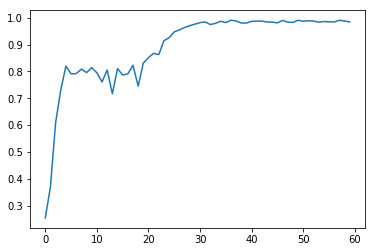

In [115]:
plt.plot(acc_list[::]);

(0.95, 1)

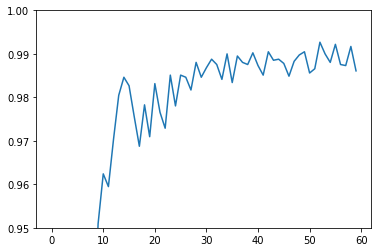

In [116]:
plt.plot(bce_acc_list[::]);
plt.ylim([0.95, 1])

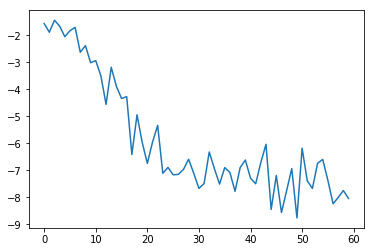

In [117]:
plt.plot(loss_list[::]);

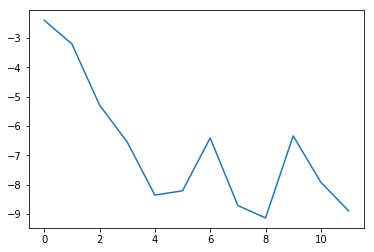

In [118]:
plt.plot(overall_val_loss_list);

## Plots for model output

In [123]:
test_loss_list = []
test_acc_list = []

model.eval()
bce_model.eval()
for test_inputs, test_true_labels in test_loader:

    if test_inputs.shape[0] < batch_size:
        break
    test_inputs, test_true_labels = test_inputs.to(device), test_true_labels.to(device)
    test_predictions = model(test_inputs)
    test_predictions_bce = bce_model(test_inputs)
    
model.train()
bce_model.train();

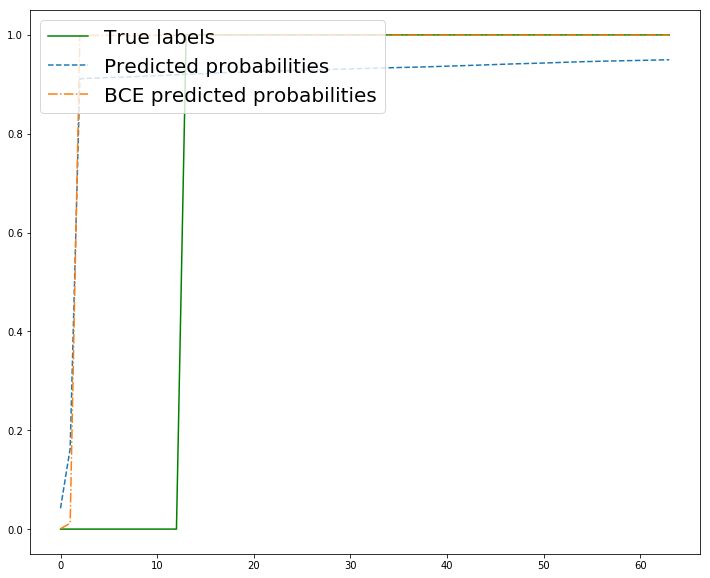

In [124]:
index = 15
plt.figure(figsize=(12, 10))
plt.plot(test_true_labels[index].cpu().detach().numpy(), color='green', label='True labels')
plt.plot(test_predictions[index].cpu().detach().numpy(), '--', label='Predicted probabilities')
plt.plot(test_predictions_bce[index].cpu().detach().numpy(), '-.', label='BCE predicted probabilities')
plt.legend(loc='upper left', fontsize=20);
plt.ylim([-.05, 1.05]);

## Calculate metrics for different models

In [125]:
def evaluate_metrics(y_true, y_pred, threshold=0.5):
    """
    Evaluate metrics for change point detection
    We assume, that there is no more than one change index in data (so, either 0 or 1 change)
    Inputs
    y_true : torch.Tensor
      true labels
    y_pred : torch.Tensor
      change probabiltiy
    threshold : float
      detection threshold
      
    Returns
    false_positive : int
      number of false positives
    false_negative : int
      number of false negatives
    delay : int
      detection delay
    accuracy : float
      y_pred accuracy given y_truei
    """
    delay = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    index_real = torch.where(y_true != y_true[0])[0] # indexes with real changes
    index_detected = torch.where((y_pred > threshold).long() != y_true[0])[0] # indexes with predicted changes

    if len(index_real) > 0:
        real_change_index = index_real[0]

        if len(index_detected) > 0:
            index_sub_detected = torch.where(index_detected >= real_change_index)[0]

            if len(index_sub_detected) == len(index_detected):
                false_positive_delay = real_change_index.item()
                detected_change_index = index_detected[0]
                delay = (detected_change_index - real_change_index).item()
            else:
                false_positive_delay = index_detected[0].item()
                delay = 0
                false_positive += 1
                
        else:
            false_positive_delay = seq_len
            delay = (seq_len - real_change_index).item()
            false_negative += 1

    else:
        if len(index_detected) > 0:
            false_positive_delay = index_detected[0].item()
            false_positive += 1
        else:
            false_positive_delay = seq_len
            true_negative += 1
    
    accuracy = ((y_pred > threshold).long() == y_true).float().mean().item()
    
    return false_positive, false_negative, delay, false_positive_delay, accuracy

In [126]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size)

In [130]:
def get_quality_metrics(test_loader, model, threshold=0.5):
    test_loss_list = []
    test_acc_list = []

    positive_number = 0 
    negative_number = 0
    fp_list = []
    fn_list = []
    delay_list = []
    fp_delay_list = []
    accuracy_list = []

    model.eval()
    for test_inputs, test_true_labels in test_loader:

        if test_inputs.shape[0] < test_batch_size:
            break

        test_inputs, test_true_labels = test_inputs.to(device), test_true_labels.to(device)
        test_predictions = model(test_inputs)
        test_loss = loss_function(test_predictions.squeeze(), test_true_labels.float())
        test_loss_list += [test_loss.cpu().clone().detach()]

        for i in range(0, test_batch_size):
            curr_labels = test_true_labels[i]
            curr_predictions = test_predictions[i]
            
            # torch.rand_like
            curr_fp, curr_fn, curr_delay, curr_fp_delay, curr_accuracy = evaluate_metrics(curr_labels, curr_predictions, 
                                                                           threshold)

            max_difference = np.abs((curr_labels.max() - curr_labels.min()).item())
            if max_difference: 
                delay_list.append(curr_delay)
            positive_number += (max_difference > 0)
            negative_number += 1 - (max_difference > 0)

            fp_list.append(curr_fp)
            fn_list.append(curr_fn)
            fp_delay_list.append(curr_fp_delay)
            accuracy_list.append(curr_accuracy)

        test_acc_list.append(np.mean(accuracy_list[-test_batch_size:]))
        
    return (positive_number, negative_number, np.mean(test_loss_list), np.mean(test_acc_list), np.mean(delay_list),
            np.mean(fp_delay_list), np.sum(fp_list), np.sum(fn_list))

In [131]:
(positive_number, negative_number, test_loss, 
test_acc, mean_delay, mean_fp_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, 0.1)
    
print("Positive number: ", positive_number)
print("Negative number: ", negative_number)
print("Test loss: {:.3f}".format(test_loss))
print("Test accuracy: {:.3f}".format(test_acc))
print("Test delay: {:.2f}".format(mean_delay))
print("Test FP delay: {:.2f}".format(mean_fp_delay))
print("Test FP: ", fp_number)
print("Test FN: ", fn_number)

# custom loss metrics:
# Test loss: -18.444
# Test accuracy: 0.850%
# Test delay: 0.05
# Test FP:  93
# Test FN:  0

Positive number:  40
Negative number:  24
Test loss: -5.739
Test accuracy: 0.936
Test delay: 0.15
Test FP delay: 33.09
Test FP:  37
Test FN:  0


In [132]:
def get_pareto_metrics_for_threshold(model, test_loader, threshold_list):
    fp_number_list = []
    fn_number_list = []
    delay_list = []
    fp_delay_list = []
    for threshold in threshold_list:
        # test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

        (positive_number, negative_number, test_loss, 
         test_acc, mean_delay, mean_fp_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, threshold)

        fp_number_list.append(fp_number)
        fn_number_list.append(fn_number)
        delay_list.append(mean_delay)
        fp_delay_list.append(mean_fp_delay)
        print(threshold, fp_number, fn_number, mean_delay, mean_fp_delay)
    
    return fp_number_list, fn_number_list, delay_list, fp_delay_list

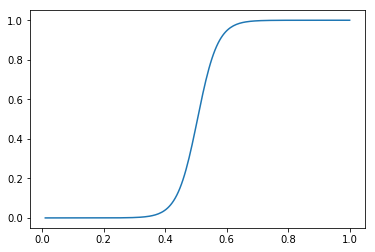

In [133]:
threshold_number = 200
threshold_list = np.linspace(-15, 15, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
plt.plot(np.linspace(0.01, 1, threshold_number), threshold_list)

In [134]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

In [135]:
(fp_number_list, fn_number_list, 
 delay_list, fp_delay_list) = get_pareto_metrics_for_threshold(model, final_test_loader, threshold_list)

3.059022269256247e-07 64 0 0.0 0.0
3.5567566069455447e-07 64 0 0.0 0.0
4.135477399343811e-07 64 0 0.0 0.0
4.808361957083632e-07 64 0 0.0 0.0
5.590731667609661e-07 64 0 0.0 0.0
6.500400855903908e-07 64 0 0.0 0.0
7.558082407498619e-07 64 0 0.0 0.0
8.787859389250973e-07 64 0 0.0 0.0
1.0217733405942518e-06 64 0 0.0 0.0
1.1880262177800208e-06 64 0 0.0 0.0
1.3813300855273949e-06 64 0 0.0 0.0
1.6060863949070788e-06 64 0 0.0 0.0
1.8674127499275664e-06 64 0 0.0 0.0
2.171259429985438e-06 64 0 0.0 0.0
2.5245448706559623e-06 64 0 0.0 0.0
2.935313187166708e-06 64 0 0.0 0.0
3.4129173266193407e-06 64 0 0.0 0.0
3.968232018336215e-06 64 0 0.0 0.0
4.613901369867859e-06 64 0 0.0 0.0
5.3646267446155565e-06 64 0 0.0 0.0
6.2375014736103725e-06 64 0 0.0 0.0
7.2524000195603246e-06 64 0 0.0 0.0
8.43243045001736e-06 64 0 0.0 0.0
9.804460516527986e-06 64 0 0.0 0.0
1.1399729310565373e-05 64 0 0.0 0.0
1.3254558412823157e-05 64 0 0.0 0.0
1.5411178714132362e-05 64 0 0.0 0.0
1.7918691714996185e-05 64 0 0.0 0.0
2.0834

0.9999988119737823 0 41 40.73170731707317 64.0
0.9999989782266594 0 41 40.73170731707317 64.0
0.9999991212140611 0 41 40.73170731707317 64.0
0.9999992441917592 0 41 40.73170731707317 64.0
0.9999993499599145 0 41 40.73170731707317 64.0
0.9999994409268332 0 41 40.73170731707317 64.0
0.9999995191638043 0 41 40.73170731707317 64.0
0.99999958645226 0 41 40.73170731707317 64.0
0.9999996443243392 0 41 40.73170731707317 64.0
0.999999694097773 0 41 40.73170731707317 64.0


In [136]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_combined, fn_number_list_combined, 
 delay_list_combined, fp_delay_list_combined) = get_pareto_metrics_for_threshold(combined_model, final_test_loader, 
                                                                                             threshold_list)

3.059022269256247e-07 64 0 0.0 0.0
3.5567566069455447e-07 64 0 0.0 0.0
4.135477399343811e-07 64 0 0.0 0.0
4.808361957083632e-07 64 0 0.0 0.0
5.590731667609661e-07 64 0 0.0 0.0
6.500400855903908e-07 64 0 0.0 0.0
7.558082407498619e-07 64 0 0.0 0.0
8.787859389250973e-07 64 0 0.0 0.0
1.0217733405942518e-06 64 0 0.0 0.0
1.1880262177800208e-06 64 0 0.0 0.0
1.3813300855273949e-06 64 0 0.0 0.0
1.6060863949070788e-06 64 0 0.0 0.0
1.8674127499275664e-06 64 0 0.0 0.0
2.171259429985438e-06 64 0 0.0 0.0
2.5245448706559623e-06 64 0 0.0 0.0
2.935313187166708e-06 64 0 0.0 0.0
3.4129173266193407e-06 64 0 0.0 0.0
3.968232018336215e-06 64 0 0.0 0.0
4.613901369867859e-06 64 0 0.0 0.0
5.3646267446155565e-06 64 0 0.0 0.0
6.2375014736103725e-06 64 0 0.0 0.0
7.2524000195603246e-06 64 0 0.0 0.0
8.43243045001736e-06 64 0 0.0 0.0
9.804460516527986e-06 64 0 0.0 0.0
1.1399729310565373e-05 64 0 0.0 0.0
1.3254558412823157e-05 64 0 0.0 0.0
1.5411178714132362e-05 64 0 0.0 0.0
1.7918691714996185e-05 64 0 0.0 0.0
2.0834

0.99999813258725 0 41 40.73170731707317 64.0
0.999998393913605 0 41 40.73170731707317 64.0
0.9999986186699144 0 41 40.73170731707317 64.0
0.9999988119737823 0 41 40.73170731707317 64.0
0.9999989782266594 0 41 40.73170731707317 64.0
0.9999991212140611 0 41 40.73170731707317 64.0
0.9999992441917592 0 41 40.73170731707317 64.0
0.9999993499599145 0 41 40.73170731707317 64.0
0.9999994409268332 0 41 40.73170731707317 64.0
0.9999995191638043 0 41 40.73170731707317 64.0
0.99999958645226 0 41 40.73170731707317 64.0
0.9999996443243392 0 41 40.73170731707317 64.0
0.999999694097773 0 41 40.73170731707317 64.0


In [137]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_bce, fn_number_list_bce, 
 delay_list_bce, fp_delay_list_bce) = get_pareto_metrics_for_threshold(bce_model, final_test_loader, 
                                                                       threshold_list)



3.059022269256247e-07 64 0 0.0 0.0
3.5567566069455447e-07 64 0 0.0 0.0
4.135477399343811e-07 64 0 0.0 0.0
4.808361957083632e-07 64 0 0.0 0.0
5.590731667609661e-07 64 0 0.0 0.0
6.500400855903908e-07 64 0 0.0 0.0
7.558082407498619e-07 64 0 0.0 0.0
8.787859389250973e-07 64 0 0.0 0.0
1.0217733405942518e-06 64 0 0.0 0.0
1.1880262177800208e-06 64 0 0.0 0.0
1.3813300855273949e-06 64 0 0.0 0.0
1.6060863949070788e-06 64 0 0.0 0.0
1.8674127499275664e-06 64 0 0.0 0.0
2.171259429985438e-06 64 0 0.0 0.0
2.5245448706559623e-06 64 0 0.0 0.0
2.935313187166708e-06 64 0 0.0 0.0
3.4129173266193407e-06 64 0 0.0 0.03125
3.968232018336215e-06 64 0 0.0 0.234375
4.613901369867859e-06 64 0 0.0 0.3125
5.3646267446155565e-06 64 0 0.0 0.375
6.2375014736103725e-06 64 0 0.0 0.421875
7.2524000195603246e-06 64 0 0.0 0.453125
8.43243045001736e-06 64 0 0.0 0.484375
9.804460516527986e-06 64 0 0.0 0.515625
1.1399729310565373e-05 64 0 0.0 0.546875
1.3254558412823157e-05 63 0 0.0 1.578125
1.5411178714132362e-05 63 0 0.0 1.

0.9999867454415872 0 9 17.609756097560975 43.53125
0.9999886002706894 0 9 18.0 43.53125
0.9999901955394834 0 10 19.195121951219512 43.859375
0.9999915675695499 0 12 19.829268292682926 45.4375
0.9999927475999804 0 12 20.317073170731707 45.4375
0.9999937624985265 0 14 22.195121951219512 46.640625
0.9999946353732554 0 16 23.5609756097561 47.5625
0.99999538609863 0 17 24.658536585365855 48.140625
0.9999960317679817 0 18 25.073170731707318 48.71875
0.9999965870826732 0 21 26.26829268292683 50.703125
0.9999970646868129 0 22 26.73170731707317 51.546875
0.9999974754551293 0 24 28.853658536585368 52.875
0.9999978287405701 0 26 29.414634146341463 53.875
0.99999813258725 0 26 29.585365853658537 53.875
0.999998393913605 0 26 29.804878048780488 53.875
0.9999986186699144 0 27 30.975609756097562 54.5
0.9999988119737823 0 27 31.51219512195122 54.5
0.9999989782266594 0 28 31.926829268292682 55.359375
0.9999991212140611 0 29 33.09756097560975 56.296875
0.9999992441917592 0 29 33.31707317073171 56.296875

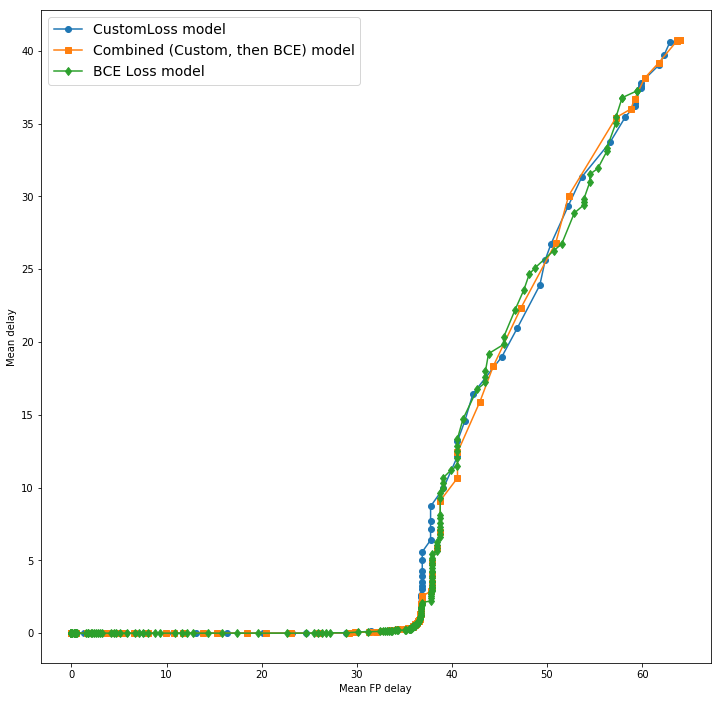

In [138]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list, delay_list, '-o', label='CustomLoss model')
plt.plot(fp_delay_list_combined, delay_list_combined, '-s', label='Combined (Custom, then BCE) model')
plt.plot(fp_delay_list_bce, delay_list_bce, '-d', label='BCE Loss model')
# plt.ylim([0, 25])
# plt.plot(fp_number_list_random, fn_number_list_random, '--s', label='Random model')
plt.xlabel('Mean FP delay')
plt.ylabel('Mean delay')
#plt.yscale('log')
# plt.xlim([32, 40])
plt.legend(loc='upper left', fontsize=14);

In [43]:
# threshold_number = 50
# fp_number_list_random = []
# fn_number_list_random = []
# for threshold in np.linspace(0.9, 1, threshold_number):
#     print(threshold)
#     # test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)
    
#     (positive_number, negative_number, test_loss, 
#      test_acc, mean_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, threshold)
    
#     fp_number_list_random.append(fp_number)
#     fn_number_list_random.append(fn_number)

In [ ]:
# plt.figure(figsize=(12, 12))
# plt.plot(fp_number_list, fn_number_list, 'o', label='CustomLoss model')
# plt.plot(fp_number_list_bce, fn_number_list_bce, 'd', label='BCE Loss model')
# # plt.plot(fp_number_list_random, fn_number_list_random, '--s', label='Random model')
# plt.xlabel('FP')
# plt.ylabel('FN')
# plt.legend(loc='upper right', fontsize=20)

In [ ]:
# plt.figure(figsize=(12, 12))
# plt.plot(fp_number_list, delay_list, '-o', label='CustomLoss model')
# plt.plot(fp_number_list_combined, delay_list_combined, '-o', label='Combined (Custom, then BCE) model')
# plt.plot(fp_number_list_bce, delay_list_bce, '--d', label='BCE Loss model')
# # plt.ylim([0, 25])
# # plt.plot(fp_number_list_random, fn_number_list_random, '--s', label='Random model')
# plt.xlabel('FP')
# plt.ylabel('Mean delay')
# plt.yscale('log')
# plt.legend(loc='upper right', fontsize=20);